/data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Initial SSIM: 0.89333
Current MS-SSIM = 0.89333
Current MS-SSIM = 0.83069
Current MS-SSIM = 0.76742
Current MS-SSIM = 0.70475
Current MS-SSIM = 0.64347
Current MS-SSIM = 0.58422
Current MS-SSIM = 0.52769
Current MS-SSIM = 0.47485
Current MS-SSIM = 0.42684
Current MS-SSIM = 0.38483
Current MS-SSIM = 0.34957
Current MS-SSIM = 0.32110
Current MS-SSIM = 0.29875
Current MS-SSIM = 0.28146
Current MS-SSIM = 0.26801
Current MS-SSIM = 0.25731
Current MS-SSIM = 0.24840
Current MS-SSIM = 0.24055
Current MS-SSIM = 0.23327
Current MS-SSIM = 0.22626


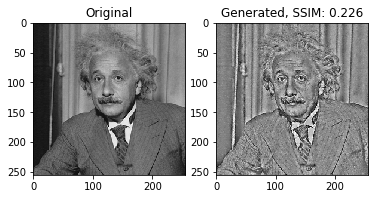

In [2]:
import sys
sys.path.insert(1, 'pytorch-msssim')
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from pytorch_msssim import msssim, ssim
import torch
from torch import optim
from imageio import imread
import numpy as np

# display = True requires matplotlib
display = True
metric = 'SSIM' # MSSSIM or SSIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def post_process(img):
    img = img.detach().cpu().numpy()
    img = np.transpose(np.squeeze(img, axis=0), (1, 2, 0))
    img = np.squeeze(img)     # works if grayscale
    return img

# Preprocessing
np_img1 = imread('./pytorch-msssim/einstein.png')

if len(np_img1.shape) == 2:                  # if no channel dimension exists
    np_img1 = np.expand_dims(np_img1, axis=-1)
np_img1 = np.transpose(np_img1, (2, 0, 1))   # adjust dimensions for pytorch
np_img1 = np.expand_dims(np_img1, axis=0)    # add batch dimension
np_img1 = np_img1 / 255.0                    # normalize values between 0-1
np_img1 = np_img1.astype(np.float32)         # adjust type

img1 = torch.from_numpy(np_img1)
img2 = torch.rand(img1.size())
img2 = torch.nn.functional.sigmoid(img2)     # use sigmoid to map values between 0-1

img1 = img1.to(device)
img2 = img2.to(device)

img1.requires_grad = False
img2.requires_grad = True

loss_func = msssim if metric == 'MSSSIM' else ssim

value = loss_func(img1, img2)
print("Initial %s: %.5f" % (metric, value.item()))

optimizer = optim.Adam([img2], lr=0.01)

# MSSSIM yields higher values for worse results, because noise is removed in scales with lower resolutions
threshold = 0.999 if metric == 'MSSSIM' else 0.9

for i in range(20):
    optimizer.zero_grad()
    msssim_out = loss_func(img1, img2)
    value = msssim_out.item()
    print('Current MS-SSIM = %.5f' % value)
    msssim_out.backward()
    optimizer.step()

if display:
    # Post processing
    img1np = post_process(img1)
    img2 = torch.nn.functional.sigmoid(img2)
    img2np = post_process(img2)
    import matplotlib.pyplot as plt
    cmap = 'gray' if len(img1np.shape) == 2 else None
    plt.subplot(1, 2, 1)
    plt.imshow(img1np, cmap=cmap)
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.imshow(img2np, cmap=cmap)
    plt.title('Generated, {:s}: {:.3f}'.format(metric, value))
    plt.show()